# importok, adattranszformaciok

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  
import os
import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix,f1_score, precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from skopt.space import Real, Integer
from skopt import BayesSearchCV

In [4]:
with open('model_ready_dict.pickle', 'rb') as handle:
    model_ready_dict = pickle.load(handle)

for key, df in model_ready_dict.items():
    name = key.replace(" ", "_").lower()
    globals()[name] = df

In [ ]:
def convert_decimal_odds_to_probabilities(dfs_dict, odds_columns):

    for key, df in dfs_dict.items():
        for col in odds_columns:
            df[f'prob_{col}'] = 1 / df[col] 
    return dfs_dict



odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
model_ready_dict = convert_decimal_odds_to_probabilities(model_ready_dict, odds)

In [ ]:
for key, df in model_ready_dict.items():
    name = key.replace(" ", "_").lower()
    globals()[name] = df

In [ ]:
big5 = pd.read_excel("big5_sorted_by_date.xlsx")
big5.drop(columns='Unnamed: 0', inplace=True)

def convert_odds_big5(df, odds_columns):
    for col in odds_columns:
        df[f'prob_{col}'] = 1 / df[col]
    return df

odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']
big5 = convert_odds_big5(big5, odds)

# FTR

## PL, FTR

In [76]:
def logistic_regression_tuning(df, target_col, drop_cols=[], odds=[]):
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))
    test_n = len(df) - train_n - val_n 
    
    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:] 

    train_set = pd.concat([train_set, val_set])

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]

    X_train_odds = X_train[odds]
    X_val_odds = X_val[odds]
    X_train = X_train.drop(columns=odds)
    X_val = X_val.drop(columns=odds)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    
    X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
    X_val_scaled = pd.concat([X_val_scaled, X_val_odds], axis=1)
    
    param_space = [
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l1'],
         'solver': ['liblinear', 'saga'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l2'],
         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['elasticnet'],
         'solver': ['saga'],  
         'l1_ratio': Real(0, 1),
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    ]


    tscv = TimeSeriesSplit(n_splits=5) 
    
    log_reg = LogisticRegression(random_state=1, max_iter=1000)

    bayes_search = BayesSearchCV(
        estimator=log_reg,
        search_spaces=param_space,
        n_iter=50, 
        cv=tscv, 
        scoring='f1',
        refit='f1',
        n_jobs=-1,  
        random_state=1,
        verbose=0
    )
    
    bayes_search.fit(X_train_scaled, y_train)  
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    
    y_pred = best_model.predict(X_val_scaled)
    val_set = val_set.copy()
    val_set.loc[:, 'Predicted'] = y_pred
    
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    y_val_probs = best_model.predict_proba(X_val_scaled)
    val_set['P_0'] = y_val_probs[:, 0] 
    val_set['P_1'] = y_val_probs[:, 1]  
    print(classification_report(y_val, y_pred))
    
    plt.figure(figsize=(5, 3))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("ModelL")
    plt.ylabel("Valós")
    plt.show()
    
    feature_importances = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': np.abs(best_model.coef_).flatten()
    }).sort_values(by='importance', ascending=False)
    
    top_20_features = feature_importances.head(20)['feature'].tolist()
    print(top_20_features)

    plt.figure(figsize=(6, 4))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
    plt.xlabel("Fontosság (koef.)")
    plt.ylabel("Változó")
    plt.grid(axis='x')
    plt.show()
    
    return val_set, best_params, top_20_features

Accuracy: 0.6757
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       190
           1       0.67      0.67      0.67       180

    accuracy                           0.68       370
   macro avg       0.68      0.68      0.68       370
weighted avg       0.68      0.68      0.68       370



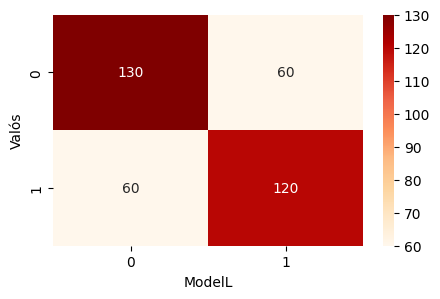

['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_U2.5_odds_market', 'away_expected_points_RA', 'away_goals_for_RA', 'home_points_cumulative', 'home_np_xg_difference_RA', 'away_last5_over_2_5_count', 'home_cumulative_goals_diff', 'home_shots_OT_RA', 'home_ppda_RA', 'home_last5_under_2_5_count', 'home_last5_draw_rate', 'home_np_xg_RA', 'home_last5_wins_count', 'away_last5_wins_count', 'home_expected_points_RA', 'away_ppda_RA', 'home_deep_completions_RA', 'away_points_cumulative']


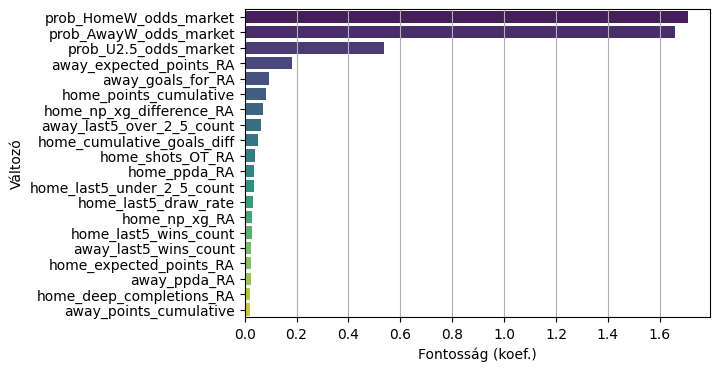

In [16]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


premier_league_tuned_home, premier_league_params_home, premier_league_features_home = logistic_regression_tuning(
    premier_league,
    target_col,
    drop,
    odds
)

Accuracy: 0.6405
              precision    recall  f1-score   support

           0       0.82      0.63      0.72       265
           1       0.42      0.66      0.51       105

    accuracy                           0.64       370
   macro avg       0.62      0.65      0.61       370
weighted avg       0.71      0.64      0.66       370



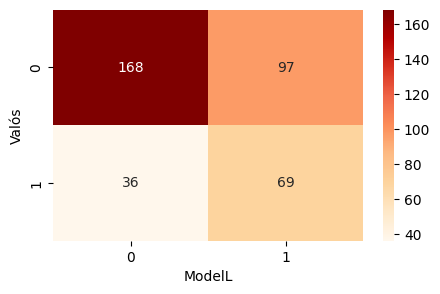

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'prob_O2.5_odds_market', 'away_np_xg_difference_RA', 'away_xg_RA', 'home_np_xg_difference_RA', 'home_expected_points_RA', 'prob_Draw_odds_market', 'away_expected_points_RA', 'prob_U2.5_odds_market', 'away_last5_losses_count', 'cumulative_points_diff', 'away_cumulative_goals_diff', 'home_halftime_goals_RA', 'home_last5_wins_count', 'home_last5_losses_count', 'draw_rate_diff', 'away_shots_RA', 'away_halftime_goals_RA', 'away_last5_under_2_5_count']


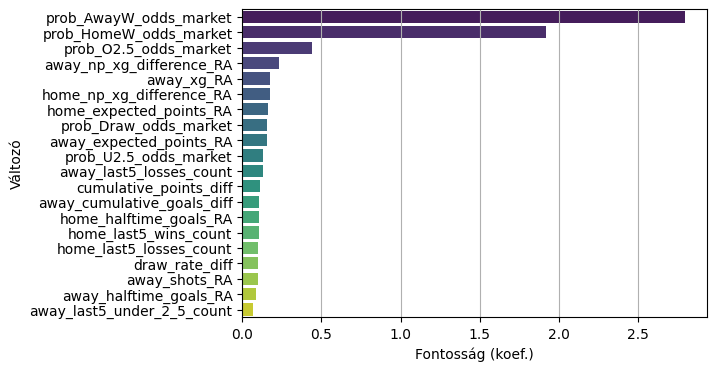

In [17]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

premier_league_tuned_away, premier_league_params_away,premier_league_features_away = logistic_regression_tuning(
    premier_league,
    target_col,
    drop,
    odds
)

### tuned model on train+validation

In [18]:
def logreg_validation(df, target_col, drop_cols=[], odds = [], best_params={}):

    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))
    test_n = len(df) - train_n - val_n 
    
    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:] 

    train_set = pd.concat([train_set, val_set])

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]

    X_train_odds = X_train[odds]
    X_val_odds = X_val[odds]
    X_train = X_train.drop(columns=odds)
    X_val = X_val.drop(columns=odds)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
    X_val_scaled = pd.concat([X_val_scaled, X_val_odds], axis=1)

    logreg = LogisticRegression(
        C=best_params.get('C', 1.0),
        penalty=best_params.get('penalty', 'l2'),
        solver=best_params.get('solver', 'liblinear'),
        class_weight=best_params.get('class_weight', None),
        random_state=best_params.get('random_state', 1),
        max_iter=1000,
        l1_ratio=best_params.get('l1_ratio', 0.5) if best_params.get('penalty') == 'elasticnet' else None  
    )
    
    logreg.fit(X_train_scaled, y_train)
    
    y_pred = logreg.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    
    val_set = val_set.copy()
    val_set.loc[:, 'Predicted'] = y_pred
    
    return logreg

In [49]:
def logreg_final(df, drop_cols_home=[], drop_cols_away=[], odds = [], best_params_home={}, best_params_away={}):
    
    df = df.dropna().reset_index(drop=True)
    
    lr_home = logreg_validation(df, "target_home_win", drop_cols_home, odds, best_params_home)
    lr_away = logreg_validation(df, "target_away_win", drop_cols_away, odds, best_params_away)
    
    train_size = 0.9
    test_size = 0.1
    split_idx = int(len(df) * train_size)
    
    print(f"Tanuló halmaz: 1 -> {split_idx}")
    print(f"teszt halmaz: {split_idx+1} -> {len(df)}")
    
    X_train = df.iloc[:split_idx].reset_index(drop=True)
    X_test = df.iloc[split_idx:].reset_index(drop=True)
    
    X_train_model = X_train.drop(columns=["target_home_win", "target_away_win"] + drop_cols_home + drop_cols_away)
    X_test_model = X_test.drop(columns=["target_home_win", "target_away_win"] + drop_cols_home + drop_cols_away)
    
    X_train_odds = X_train_model[odds]
    X_test_odds = X_test_model[odds]
    
    X_train_model = X_train_model.drop(columns=odds)
    X_test_model = X_test_model.drop(columns=odds)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_model)
    X_test_scaled = scaler.transform(X_test_model)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_model.columns, index=X_train_model.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_model.columns, index=X_test_model.index)
    
    X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, X_test_odds], axis=1)
    
    y_train_home = X_train["target_home_win"]
    y_train_away = X_train["target_away_win"]
    
    y_test_home = X_test["target_home_win"]
    y_test_away = X_test["target_away_win"]

    y_test_draw = X_test["target_draw"]
    
    model_home_preds = lr_home.predict(X_test_scaled)
    model_away_preds = lr_away.predict(X_test_scaled)
    
    prob_home_win = lr_home.predict_proba(X_test_scaled)[:, 1]
    prob_away_win = lr_away.predict_proba(X_test_scaled)[:, 1]
    
    prob_home_win = np.maximum(prob_home_win, 0)
    prob_away_win = np.maximum(prob_away_win, 0)
    
    best_f1_macro = 0
    best_threshold = 0.15
    best_secondary_threshold = 0.4
    thresholds = np.arange(0.01, 0.30, 0.01)
    secondary_thresholds = np.arange(0.2, 0.7, 0.01)
    
    for threshold in thresholds:
        for secondary_threshold in secondary_thresholds:
            predictions = []
            for i in range(len(X_test)):
                home_prob = prob_home_win[i]
                away_prob = prob_away_win[i]
                
                if abs(home_prob - away_prob) < threshold and max(home_prob, away_prob) < secondary_threshold:
                    predictions.append("Draw")
                elif home_prob > away_prob:
                    predictions.append("Home Win")
                else:
                    predictions.append("Away Win")
            
            true_outcomes = []
            for i in range(len(X_test)):
                if y_test_home.iloc[i] == 1:
                    true_outcomes.append("Home Win")
                elif y_test_away.iloc[i] == 1:
                    true_outcomes.append("Away Win")
                else:
                    true_outcomes.append("Draw")
            
            f1_macro = f1_score(true_outcomes, predictions, average='macro')
            
            if f1_macro > best_f1_macro:
                best_f1_macro = f1_macro
                best_threshold = threshold
                best_secondary_threshold = secondary_threshold
    
    df.loc[df.index[-len(X_test):], "model_home"] = model_home_preds
    df.loc[df.index[-len(X_test):], "model_away"] = model_away_preds
    
    prob_home_win = np.maximum(prob_home_win, 0)
    prob_away_win = np.maximum(prob_away_win, 0)
    prob_draw = np.maximum(1 - (prob_home_win + prob_away_win), 0)
    
    total_prob = prob_home_win + prob_away_win + prob_draw
    prob_home_win /= total_prob
    prob_away_win /= total_prob
    prob_draw /= total_prob
    
    df.loc[df.index[-len(X_test):], "prob_home_win"] = prob_home_win
    df.loc[df.index[-len(X_test):], "prob_away_win"] = prob_away_win
    df.loc[df.index[-len(X_test):], "prob_draw"] = prob_draw
    df.loc[df.index[-len(X_test):], "best_threshold"] = best_threshold
    df.loc[df.index[-len(X_test):], "best_secondary_threshold"] = best_secondary_threshold
    
    def voting_hard(row):
        if row["model_home"] == 1 and row["model_away"] == 0:
            return "Home Win"
        elif row["model_away"] == 1 and row["model_home"] == 0:
            return "Away Win"
        elif row["model_home"] == 0 and row["model_away"] == 0:
            return "Draw"
        elif row["model_home"] == 1 and row["model_away"] == 1:
            return "Home Win"
        else:
            return "-"
    
    def voting_soft(row):
        prob_home_win = row['prob_home_win']
        prob_away_win = row['prob_away_win']
        threshold = row['best_threshold']
        secondary_threshold = row['best_secondary_threshold']
        
        if abs(prob_home_win - prob_away_win) < threshold and max(prob_home_win, prob_away_win) < secondary_threshold:
            return "Draw"
        elif prob_home_win > prob_away_win:
            return "Home Win"
        elif prob_home_win < prob_away_win:
            return "Away Win"
        else:
            return "-"
    
    df["test_pred_hard"] = df.apply(voting_hard, axis=1)
    df["test_pred_soft"] = df.apply(voting_soft, axis=1)
    
    plt.figure(figsize=(3, 2))
    cm_home = confusion_matrix(df["target_home_win"].tail(len(X_test)), model_home_preds)
    sns.heatmap(cm_home, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem hazai Gy', 'Hazai Gy'], yticklabels=['Nem hazai Gy', 'Hazai Gy'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Hazai modell - refit")
    plt.show()
    
    plt.figure(figsize=(3, 2))
    cm_away = confusion_matrix(df["target_away_win"].tail(len(X_test)), model_away_preds)
    sns.heatmap(cm_away, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem vendég Gy', 'Vendég Gy'], yticklabels=['Nem vendég Gy', 'Vendég Gy'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Vendég modell - refit")
    plt.show()
    
    print(f"legjobb threshold #1: {best_threshold:.2f}")
    print(f"legjobb threshold #2: {best_secondary_threshold:.2f}")
    
    return df, lr_home, lr_away

Tanuló halmaz: 1 -> 3328
teszt halmaz: 3329 -> 3698


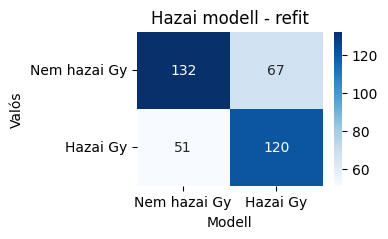

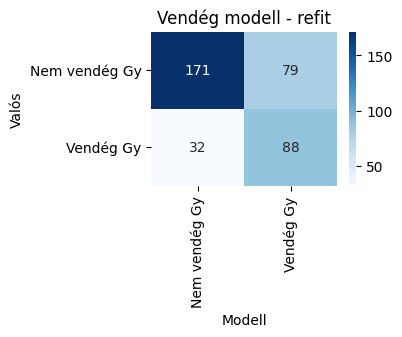

legjobb threshold #1: 0.26
legjobb threshold #2: 0.61


In [50]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


test_predictions_pl, logreg_home_pl, logreg_away_pl = logreg_final(premier_league,
                                                                   drop_cols_home, drop_cols_away,
                                                                   odds,
                                                                   premier_league_params_home,premier_league_params_away)

In [51]:
def process_predictions(df):
    df = df.dropna()

    df.loc[:, 'FTR'] = 0  
    df.loc[df['target_home_win'] == 1, 'FTR'] = 1  
    df.loc[df['target_away_win'] == 1, 'FTR'] = 2  

    df.loc[:, 'test_pred_numeric_hard'] = 0
    df.loc[df['test_pred_hard'] == "Home Win", 'test_pred_numeric_hard'] = 1  
    df.loc[df['test_pred_hard'] == "Away Win", 'test_pred_numeric_hard'] = 2 
    df.loc[df['test_pred_hard'] == "Draw", 'test_pred_numeric_hard'] = 0  

    df.loc[:, 'test_pred_numeric_soft'] = 0
    df.loc[df['test_pred_soft'] == "Home Win", 'test_pred_numeric_soft'] = 1  
    df.loc[df['test_pred_soft'] == "Away Win", 'test_pred_numeric_soft'] = 2 
    df.loc[df['test_pred_soft'] == "Draw", 'test_pred_numeric_soft'] = 0 

    selected_columns = [
        'target_home_win', 'target_away_win', 'target_draw', 'FTR',
        'test_pred_hard', 'test_pred_soft',
        'test_pred_numeric_hard', 'test_pred_numeric_soft'
    ]
    result_df = df[selected_columns]

    pred_odds = df[['FTR', 'test_pred_numeric_hard', 'test_pred_numeric_soft',
                    'HomeW_odds_market',
                    'AwayW_odds_market',
                    'Draw_odds_market']]


    return pred_odds

pred_odds_pl = process_predictions(test_predictions_pl)

Summary for HARD VOTING model


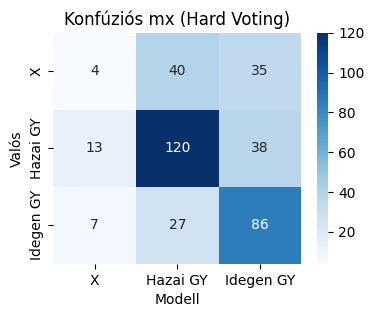

              precision    recall  f1-score   support

           0     0.1667    0.0506    0.0777        79
           1     0.6417    0.7018    0.6704       171
           2     0.5409    0.7167    0.6165       120

    accuracy                         0.5676       370
   macro avg     0.4498    0.4897    0.4548       370
weighted avg     0.5076    0.5676    0.5264       370


Summary for SOFT VOTING model


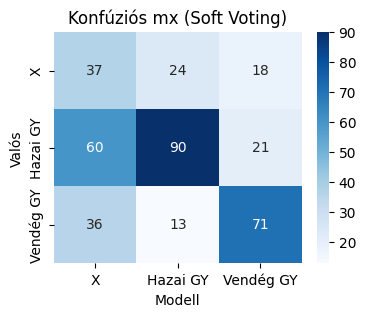

              precision    recall  f1-score   support

           0     0.2782    0.4684    0.3491        79
           1     0.7087    0.5263    0.6040       171
           2     0.6455    0.5917    0.6174       120

    accuracy                         0.5351       370
   macro avg     0.5441    0.5288    0.5235       370
weighted avg     0.5963    0.5351    0.5539       370



In [53]:
def evaluation(pred_odds):
    print("Summary for HARD VOTING model")
    cm_hard = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_hard, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['X', 'Hazai GY', 'Idegen GY'], 
                yticklabels=['X', 'Hazai GY', 'Idegen GY'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Konfúziós mx (Hard Voting)")
    plt.show()
    accuracy_hard = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    report_hard = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"], digits=4)
    print(report_hard)

    print("\nSummary for SOFT VOTING model")
    cm_soft = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_soft, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['X', 'Hazai GY', 'Vendég GY'], 
                yticklabels=['X', 'Hazai GY', 'Vendég GY'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Konfúziós mx (Soft Voting)")
    plt.show()
    accuracy_soft = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    report_soft = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"], digits=4)
    print(report_soft)

evaluation(pred_odds_pl)

In [54]:
def betting_logreg(df, stake=500):

    """
    Ezzel a fügvénnyel számolom ki a befektetés kamatát.
    Ezt külön megteszem a hard és a soft votingra.
    A tét fix, ezen lehet javítani valamilyen közgazdaságtanból származtatott optimalizálással.
    A profit definíciója a következő:
    
        (tét * historikus szorzó) - tét
    Felszummázzuk, majd a százalékos ROI-t a következőképpen kapjuk meg:
    
        (egyes meccsek profitjai felszummázva / összes elköltött pénz) * 100
    """
    df = df.copy() 

    df['Profit_hard'] = 0
    df['Profit_hard'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_hard'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_hard = df['Profit_hard'].sum()
    total_bets = len(df)

    roi_hard = (total_profit_hard / (total_bets * stake)) * 100
    
    print(f"ROI hard : {roi_hard:.2f}%")

    df['Profit_soft'] = 0
    df['Profit_soft'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_soft'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_soft = df['Profit_soft'].sum()
    total_bets = len(df)

    roi_soft = (total_profit_soft / (total_bets * stake)) * 100

    print(f"ROI soft : {roi_soft:.2f}%")

    df_profit_hard = df[df['FTR'] == df['test_pred_numeric_hard']]
    df_loss_hard = df[df['FTR'] != df['test_pred_numeric_hard']]
    
    df_profit_soft = df[df['FTR'] == df['test_pred_numeric_soft']]
    df_loss_soft = df[df['FTR'] != df['test_pred_numeric_soft']]

    return roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,df

roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(pred_odds_pl,
                                                                                                                  stake=1)

ROI hard : -1.11%
ROI soft : 4.59%


Válassz(1 vagy 2):
1 - Hard votingos ROI
2 - Soft votingos ROI
 2


>0% profit 22 fordulóban


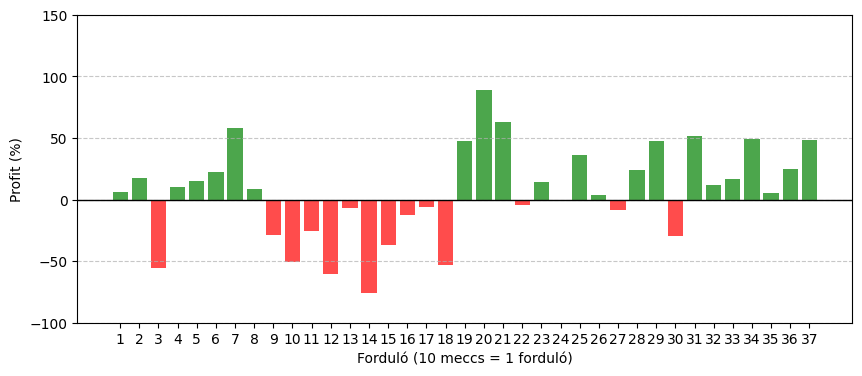

In [325]:
def ROI_sim_per_round(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    valasztas = input("Válassz(1 vagy 2):\n1 - Hard votingos ROI\n2 - Soft votingos ROI\n")
    if valasztas == "1":
        profit_column = "Profit_hard"
    elif valasztas == "2":
        profit_column = "Profit_soft"
    else:
        print("Csak 1 vagy 2 lehet az input")
        return
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({profit_column: 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round[profit_column] / (roi_per_round['Total_Bets'] * stake)) * 100

        
    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    # plt.title(f'Fogadási szimuláció, 2023-2024-es teszt szezon')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 150)  # Set y-axis limit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.savefig(r'abrak/PL_soft_ROI.jpg', format='jpg', dpi=300)
    plt.savefig(r'abrak/PL_hard_ROI.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_per_round(pred_odds_soft, round_size=10)

## Bundesliga, FTR

Accuracy: 0.6195
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       156
           1       0.59      0.64      0.61       141

    accuracy                           0.62       297
   macro avg       0.62      0.62      0.62       297
weighted avg       0.62      0.62      0.62       297



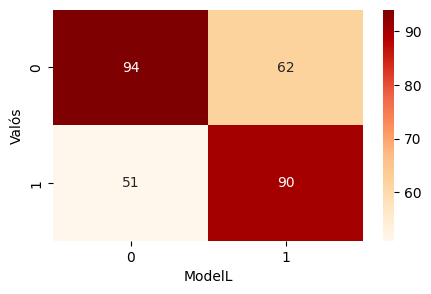

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_deep_completions_RA', 'GD_diff', 'away_np_xg_difference_RA', 'home_np_xg_difference_RA', 'away_shots_RA', 'home_halftime_goals_RA', 'away_cumulative_goals_diff', 'home_last5_under_2_5_count', 'home_points_cumulative', 'away_deep_completions_RA', 'away_halftime_goals_RA', 'away_ppda_RA', 'draw_rate_diff', 'away_np_xg_RA', 'home_shots_RA', 'away_last5_over_2_5_count', 'lose_rate_diff', 'away_last5_draw_rate']


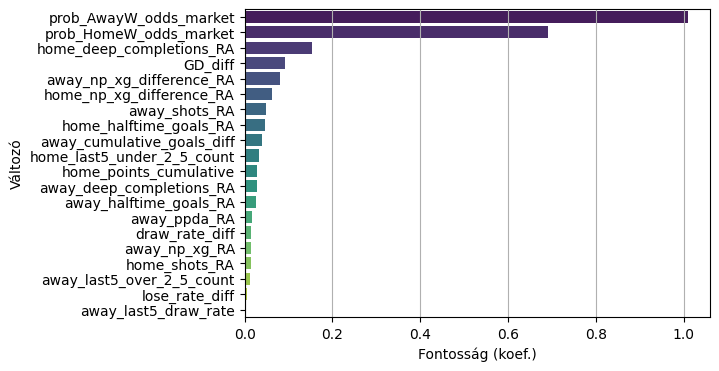

In [66]:
# target_col = 'target_home_win'
# drop = ['target_o2.5', 'target_away_win', 'target_draw']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

bundesliga_tuned_home, bundesliga_params_home, bundesliga_features_away = logistic_regression_tuning(
    bundesliga,
    target_col,
    drop,
    odds)

Accuracy: 0.6296
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       214
           1       0.39      0.58      0.47        83

    accuracy                           0.63       297
   macro avg       0.59      0.61      0.59       297
weighted avg       0.68      0.63      0.65       297



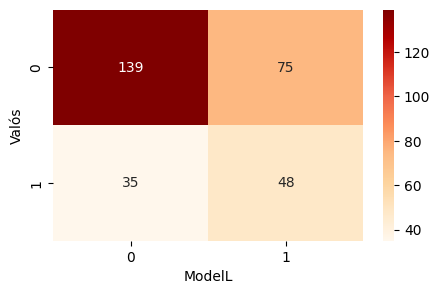

['GD_diff', 'prob_HomeW_odds_market', 'away_np_xg_difference_RA', 'away_deep_completions_RA', 'home_np_xg_difference_RA', 'home_shots_OT_RA', 'home_deep_completions_RA', 'away_cumulative_goals_diff', 'home_clinicality', 'home_points_RA', 'home_expected_points_RA', 'home_ppda_RA', 'home_np_xg_RA', 'home_cumulative_goals_diff', 'home_last5_wins_count', 'home_last5_losses_count', 'home_last5_draws_count', 'home_last5_over_2_5_count', 'home_last5_under_2_5_count', 'home_last5_win_rate']


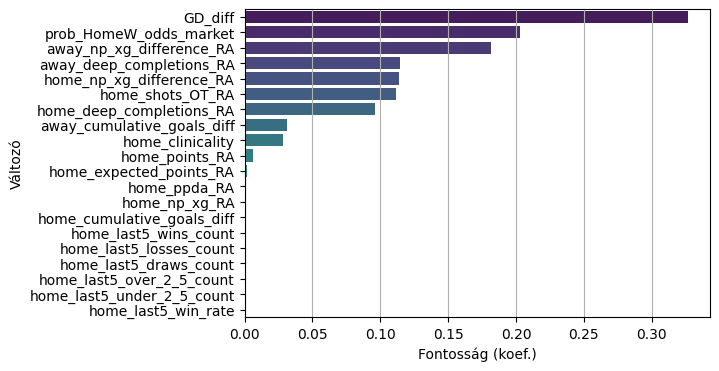

In [67]:
# target_col = 'target_away_win'
# drop = ['target_o2.5', 'target_home_win', 'target_draw']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

bundesliga_tuned_away, bundesliga_params_away, bundesliga_features_away = logistic_regression_tuning(bundesliga,
                                                                           target_col,
                                                                           drop,
                                                                           odds)

Tanuló halmaz: 1 -> 2673
teszt halmaz: 2674 -> 2970


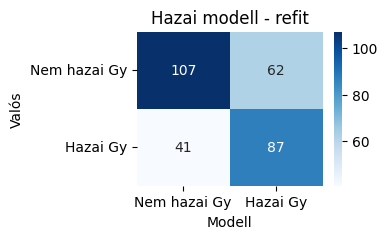

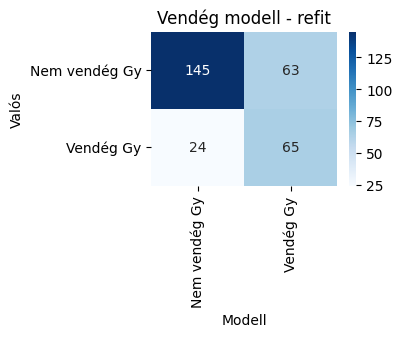

legjobb threshold #1: 0.23
legjobb threshold #2: 0.63


In [68]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


test_predictions_bundesliga, logreg_home_bundesliga, logreg_away_bundesliga = logreg_final(
    bundesliga, drop_cols_home, drop_cols_away, odds, bundesliga_params_home, bundesliga_params_away
)

Summary for HARD VOTING model


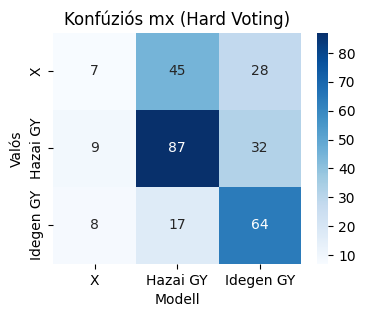

              precision    recall  f1-score   support

           0     0.2917    0.0875    0.1346        80
           1     0.5839    0.6797    0.6282       128
           2     0.5161    0.7191    0.6009        89

    accuracy                         0.5320       297
   macro avg     0.4639    0.4954    0.4546       297
weighted avg     0.4849    0.5320    0.4871       297


Summary for SOFT VOTING model


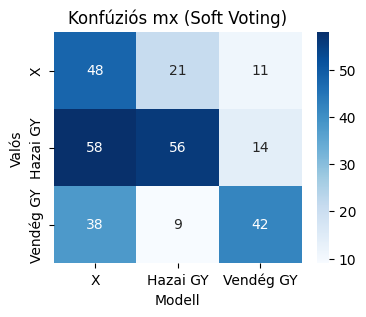

              precision    recall  f1-score   support

           0     0.3333    0.6000    0.4286        80
           1     0.6512    0.4375    0.5234       128
           2     0.6269    0.4719    0.5385        89

    accuracy                         0.4916       297
   macro avg     0.5371    0.5031    0.4968       297
weighted avg     0.5583    0.4916    0.5024       297



In [69]:
pred_odds_bundesliga = process_predictions(test_predictions_bundesliga)
evaluation(pred_odds_bundesliga)

In [70]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(
    pred_odds_bundesliga,
    stake=500)

ROI hard : 0.46%
ROI soft : 12.29%


## Serie A, FTR

Accuracy: 0.6313
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       205
           1       0.56      0.62      0.59       153

    accuracy                           0.63       358
   macro avg       0.63      0.63      0.63       358
weighted avg       0.64      0.63      0.63       358



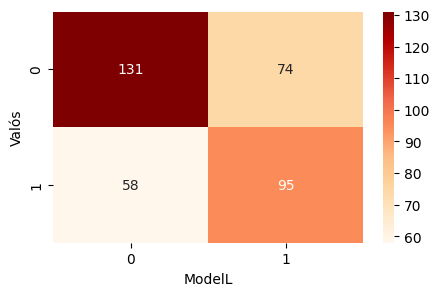

['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'home_np_xg_RA', 'cumulative_points_diff', 'home_last5_draws_count', 'GD_diff', 'home_last5_lose_rate', 'home_xg_RA', 'home_np_xg_difference_RA', 'away_cumulative_goals_diff', 'away_np_xg_difference_RA', 'home_shots_OT_RA', 'away_last5_wins_count', 'home_deep_completions_RA', 'home_last5_losses_count', 'away_points_cumulative', 'home_goals_against_RA', 'away_xg_RA', 'home_clinicality', 'away_ppda_RA']


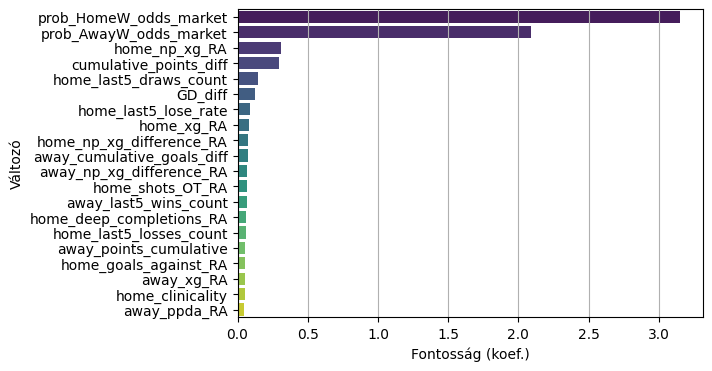

In [71]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

serie_a_tuned_home, serie_a_params_home, serie_a_features_home = logistic_regression_tuning(serie_a, target_col, drop, odds)

Accuracy: 0.6564
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       245
           1       0.47      0.64      0.54       113

    accuracy                           0.66       358
   macro avg       0.63      0.65      0.63       358
weighted avg       0.69      0.66      0.67       358



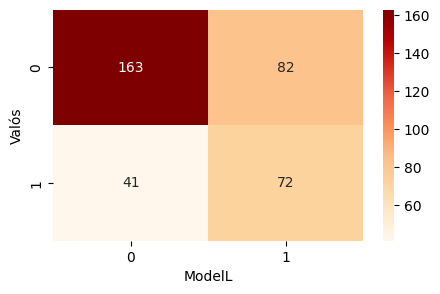

['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'home_np_xg_RA', 'away_np_xg_difference_RA', 'cumulative_points_diff', 'home_shots_OT_RA', 'home_halftime_goals_RA', 'away_cumulative_goals_diff', 'away_last5_over_2_5_count', 'home_last5_wins_count', 'away_goals_for_RA', 'home_last5_over_2_5_count', 'home_xg_RA', 'home_expected_points_RA', 'GD_diff', 'away_last5_losses_count', 'home_goals_against_RA', 'away_shots_RA', 'home_shots_RA', 'away_last5_wins_count']


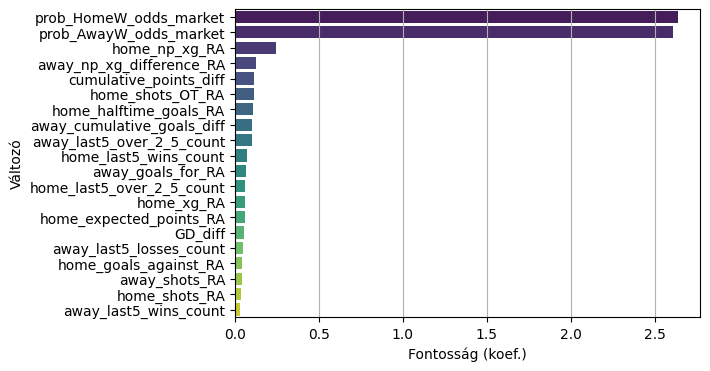

In [72]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

serie_a_tuned_away, serie_a_params_away, serie_a_features_away = logistic_regression_tuning(serie_a, target_col, drop, odds)

Tanuló halmaz: 1 -> 3220
teszt halmaz: 3221 -> 3578


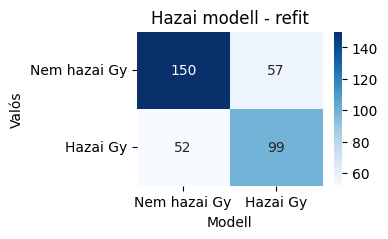

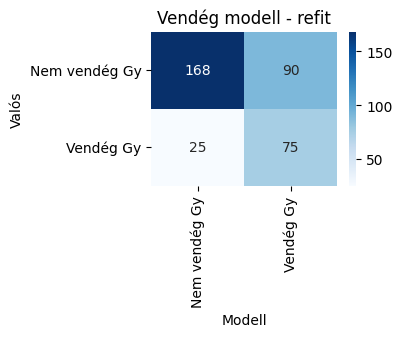

legjobb threshold #1: 0.25
legjobb threshold #2: 0.60


In [73]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_serie_a, logreg_home_serie_a, logreg_away_serie_a = logreg_final(
    serie_a, drop_cols_home, drop_cols_away, odds, serie_a_params_home, serie_a_params_away
)


Summary for HARD VOTING model


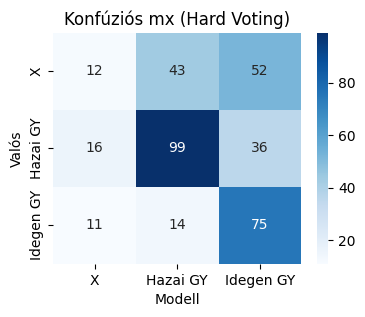

              precision    recall  f1-score   support

           0     0.3077    0.1121    0.1644       107
           1     0.6346    0.6556    0.6450       151
           2     0.4601    0.7500    0.5703       100

    accuracy                         0.5196       358
   macro avg     0.4675    0.5059    0.4599       358
weighted avg     0.4882    0.5196    0.4805       358


Summary for SOFT VOTING model


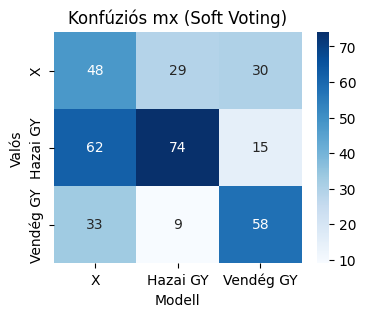

              precision    recall  f1-score   support

           0     0.3357    0.4486    0.3840       107
           1     0.6607    0.4901    0.5627       151
           2     0.5631    0.5800    0.5714       100

    accuracy                         0.5028       358
   macro avg     0.5198    0.5062    0.5061       358
weighted avg     0.5363    0.5028    0.5117       358



In [74]:
pred_odds_serie_a = process_predictions(test_predictions_serie_a)
evaluation(pred_odds_serie_a)

In [75]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(
    pred_odds_serie_a,
    stake=500)

ROI hard : 0.58%
ROI soft : 6.28%


## La Liga, FTR

Accuracy: 0.6405
              precision    recall  f1-score   support

           0       0.65      0.64      0.65       191
           1       0.63      0.64      0.63       179

    accuracy                           0.64       370
   macro avg       0.64      0.64      0.64       370
weighted avg       0.64      0.64      0.64       370



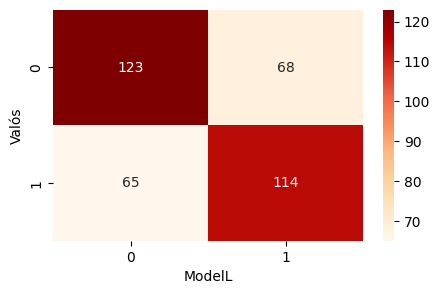

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'GD_diff', 'home_last5_under_2_5_count', 'home_goals_for_RA', 'away_expected_points_RA', 'home_last5_lose_rate', 'away_last5_wins_count', 'home_shots_OT_RA', 'away_cumulative_goals_diff', 'home_expected_points_RA', 'home_deep_completions_RA', 'home_last5_losses_count', 'away_last5_under_2_5_count', 'away_xg_RA', 'home_last5_draws_count', 'home_points_cumulative', 'home_shots_RA', 'away_last5_lose_rate', 'home_ppda_RA']


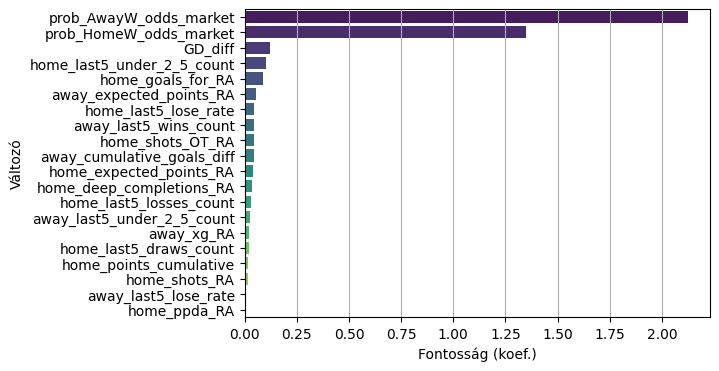

In [77]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

la_liga_tuned_home, la_liga_params_home, la_liga_features_home = logistic_regression_tuning(la_liga, target_col, drop, odds)

Accuracy: 0.6703
              precision    recall  f1-score   support

           0       0.84      0.67      0.74       265
           1       0.45      0.67      0.53       105

    accuracy                           0.67       370
   macro avg       0.64      0.67      0.64       370
weighted avg       0.73      0.67      0.69       370



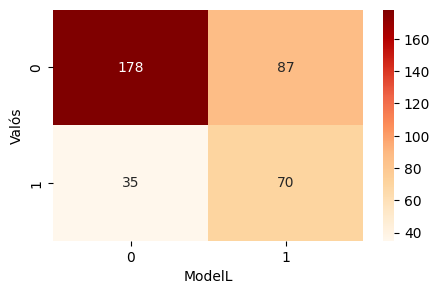

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'home_goals_for_RA', 'home_last5_under_2_5_count', 'away_last5_draw_rate', 'away_last5_losses_count', 'home_expected_points_RA', 'home_np_xg_difference_RA', 'away_last5_wins_count', 'home_halftime_goals_RA', 'home_np_xg_RA', 'away_goals_against_RA', 'home_last5_draws_count', 'home_xg_RA', 'home_last5_lose_rate', 'home_clinicality', 'away_clinicality', 'home_last5_draw_rate']


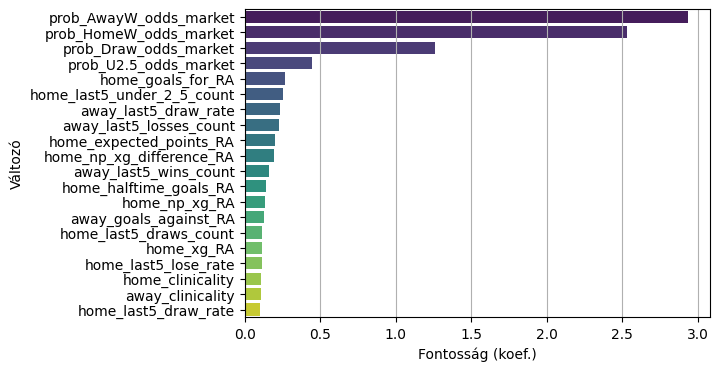

In [78]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']


target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

la_liga_tuned_away, la_liga_params_away,la_liga_features_away = logistic_regression_tuning(la_liga, target_col, drop, odds)

Tanuló halmaz: 1 -> 3327
teszt halmaz: 3328 -> 3697


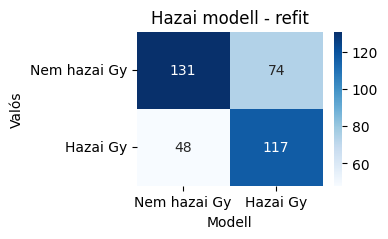

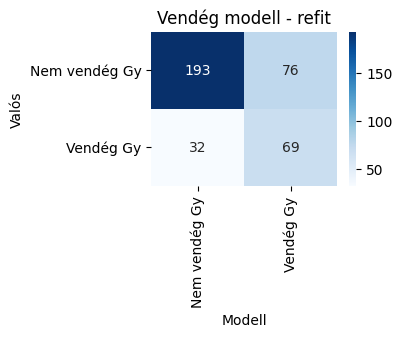

legjobb threshold #1: 0.23
legjobb threshold #2: 0.60


In [100]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_la_liga, logreg_home_la_liga, logreg_away_la_liga = logreg_final(
    la_liga, drop_cols_home, drop_cols_away, odds, la_liga_params_home, la_liga_params_away
)

Summary for HARD VOTING model


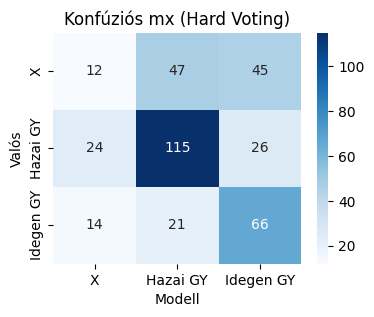

              precision    recall  f1-score   support

           0     0.2400    0.1154    0.1558       104
           1     0.6284    0.6970    0.6609       165
           2     0.4818    0.6535    0.5546       101

    accuracy                         0.5216       370
   macro avg     0.4501    0.4886    0.4571       370
weighted avg     0.4792    0.5216    0.4899       370


Summary for SOFT VOTING model


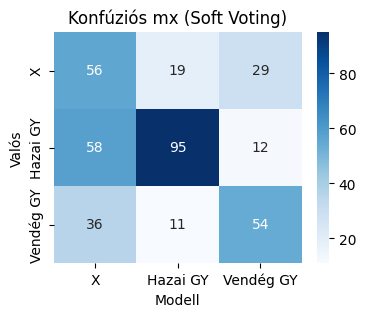

              precision    recall  f1-score   support

           0     0.3733    0.5385    0.4409       104
           1     0.7600    0.5758    0.6552       165
           2     0.5684    0.5347    0.5510       101

    accuracy                         0.5541       370
   macro avg     0.5673    0.5496    0.5490       370
weighted avg     0.5990    0.5541    0.5665       370



In [101]:
pred_odds_la_liga = process_predictions(test_predictions_la_liga)
evaluation(pred_odds_la_liga)

In [102]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(
    pred_odds_la_liga,
    stake=500)

ROI hard : -0.05%
ROI soft : 19.79%


## Ligue 1, FTR


Best model hyperparameters: OrderedDict({'C': 2.1887044253420678, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'})
Accuracy: 0.6960

Summary:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       205
           1       0.62      0.71      0.66       147

    accuracy                           0.70       352
   macro avg       0.69      0.70      0.69       352
weighted avg       0.71      0.70      0.70       352



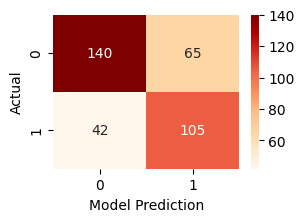


Top 20 most important features:
['prob_AwayW_odds_market', 'prob_O2.5_odds_market', 'home_last5_over_2_5_count', 'home_last5_under_2_5_count', 'away_last5_over_2_5_count', 'away_last5_under_2_5_count', 'prob_HomeW_odds_market', 'home_goals_for_RA', 'home_clinicality', 'away_expected_points_RA', 'home_xg_RA', 'away_np_xg_RA', 'away_clinicality', 'away_last5_win_rate', 'away_goals_for_RA', 'away_np_xg_difference_RA', 'away_last5_draws_count', 'away_last5_losses_count', 'home_halftime_goals_RA', 'GD_diff']


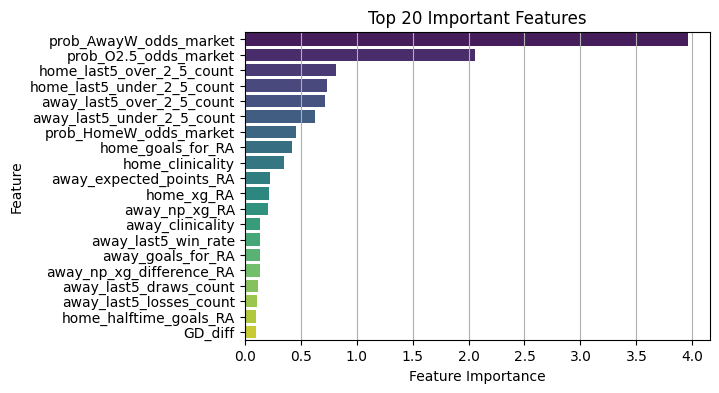

In [103]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

ligue_1_tuned_home, ligue_1_params_home, ligue_1_features_home = logistic_regression_tuning(ligue_1, target_col, drop, odds)


Best model hyperparameters: OrderedDict({'C': 0.38856665174996863, 'class_weight': 'balanced', 'max_iter': 160, 'penalty': 'l1', 'solver': 'liblinear'})
Accuracy: 0.6847

Summary:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       233
           1       0.53      0.70      0.60       119

    accuracy                           0.68       352
   macro avg       0.67      0.69      0.67       352
weighted avg       0.72      0.68      0.69       352



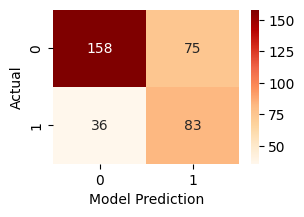


Top 20 most important features:
['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_clinicality', 'home_goals_for_RA', 'away_goals_for_RA', 'away_cumulative_goals_diff', 'home_xg_RA', 'away_last5_draw_rate', 'away_xg_RA', 'away_last5_losses_count', 'away_last5_draws_count', 'home_total_goals_RA', 'home_last5_wins_count', 'away_expected_points_RA', 'away_shots_RA', 'home_deep_completions_RA', 'home_expected_points_RA', 'away_goals_against_RA', 'home_np_xg_RA', 'home_points_cumulative']


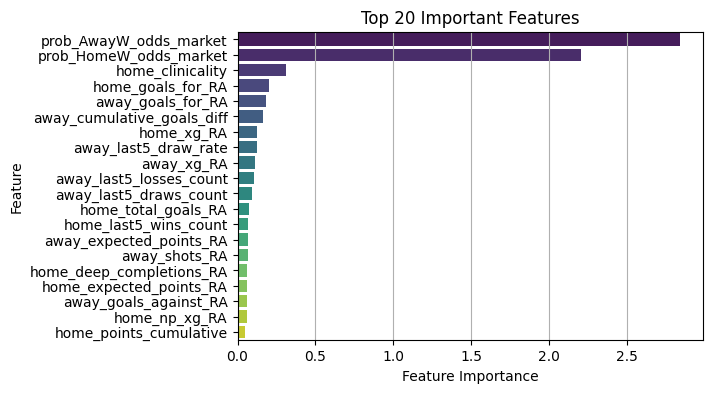

In [104]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

ligue_1_tuned_away, ligue_1_params_away, ligue_1_features_away = logistic_regression_tuning(ligue_1, target_col, drop, odds)

Tanuló halmaz: 1 -> 3168
teszt halmaz: 3169 -> 3521


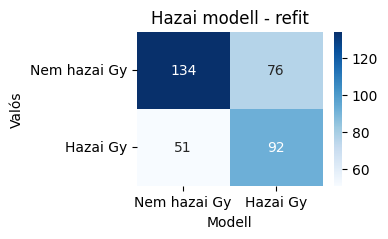

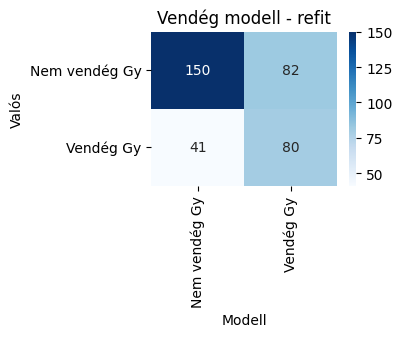

legjobb threshold #1: 0.17
legjobb threshold #2: 0.59


In [108]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_ligue_1, logreg_home_ligue_1, logreg_away_ligue_1 = logreg_final(
    ligue_1, drop_cols_home, drop_cols_away, odds, ligue_1_params_home, ligue_1_params_away
)

Summary for HARD VOTING model


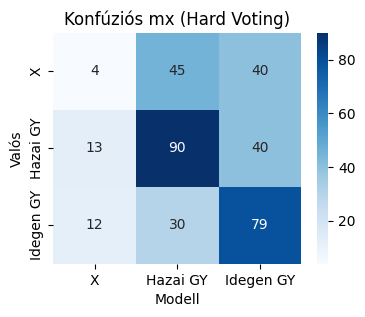

              precision    recall  f1-score   support

           0     0.1379    0.0449    0.0678        89
           1     0.5455    0.6294    0.5844       143
           2     0.4969    0.6529    0.5643       121

    accuracy                         0.4901       353
   macro avg     0.3934    0.4424    0.4055       353
weighted avg     0.4260    0.4901    0.4473       353


Summary for SOFT VOTING model


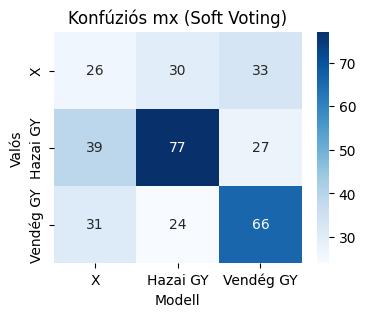

              precision    recall  f1-score   support

           0     0.2708    0.2921    0.2811        89
           1     0.5878    0.5385    0.5620       143
           2     0.5238    0.5455    0.5344       121

    accuracy                         0.4788       353
   macro avg     0.4608    0.4587    0.4592       353
weighted avg     0.4859    0.4788    0.4817       353



In [109]:
pred_odds_ligue_1 = process_predictions(test_predictions_ligue_1)
evaluation(pred_odds_ligue_1)

In [110]:
roi_hard, roi_soft, df_profit_hard, df_loss_hard, df_profit_soft, df_loss_soft, pred_odds_soft = betting_logreg(
    pred_odds_ligue_1,
    stake=500
)

ROI hard : -5.18%
ROI soft : -1.68%


## Kombinált, FTR

Accuracy: 0.6586
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       949
           1       0.62      0.64      0.63       797

    accuracy                           0.66      1746
   macro avg       0.66      0.66      0.66      1746
weighted avg       0.66      0.66      0.66      1746



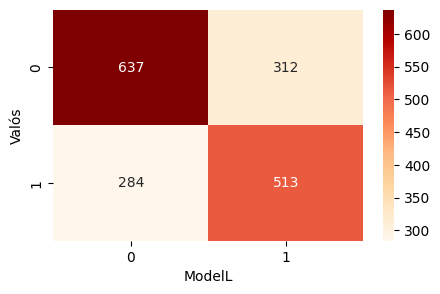

['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_U2.5_odds_market', 'away_expected_points_RA', 'home_np_xg_difference_RA', 'home_np_xg_RA', 'away_last5_wins_count', 'away_np_xg_RA', 'away_cumulative_goals_diff', 'home_goals_for_RA', 'home_last5_losses_count', 'away_last5_over_2_5_count', 'home_deep_completions_RA', 'home_last5_over_2_5_count', 'away_points_cumulative', 'home_last5_under_2_5_count', 'home_halftime_goals_RA', 'away_clinicality', 'draw_rate_diff', 'home_shots_RA']


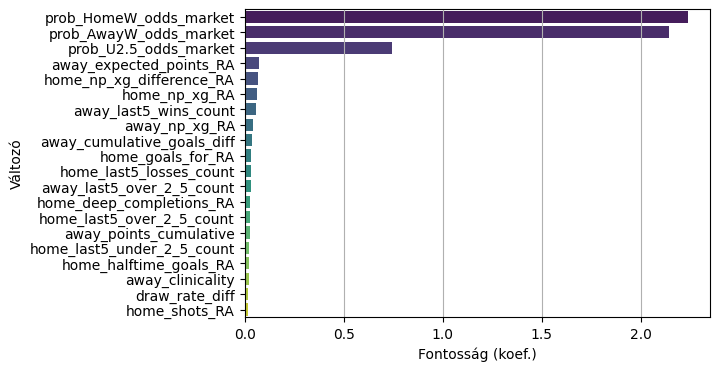

In [61]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

big5_tuned_home, big5_params_home, big5_features_home = logistic_regression_tuning(big5, target_col, drop, odds)

Accuracy: 0.6501
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1222
           1       0.44      0.65      0.53       524

    accuracy                           0.65      1746
   macro avg       0.63      0.65      0.63      1746
weighted avg       0.70      0.65      0.66      1746



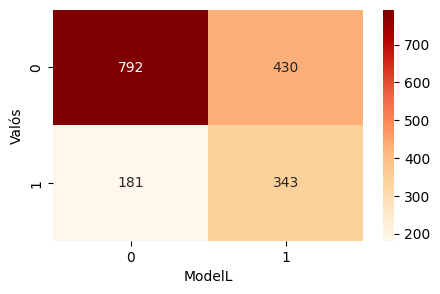

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'away_last5_draw_rate', 'home_clinicality', 'away_last5_losses_count', 'away_last5_draws_count', 'away_goals_for_RA', 'away_cumulative_goals_diff', 'away_np_xg_difference_RA', 'home_last5_under_2_5_count', 'home_shots_OT_RA', 'home_last5_losses_count', 'away_goals_against_RA', 'home_deep_completions_RA', 'home_expected_points_RA', 'away_expected_points_RA', 'home_shots_RA', 'home_halftime_goals_RA', 'away_ppda_RA', 'home_cumulative_goals_diff']


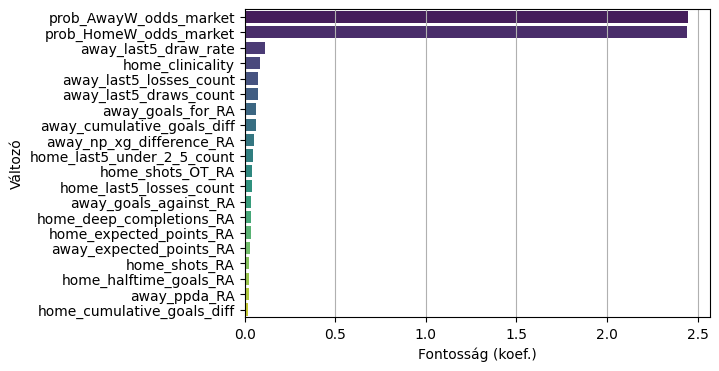

In [62]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

big5_tuned_away, big5_params_away, big5_features_away = logistic_regression_tuning(big5, target_col, drop, odds)

Tanuló halmaz: 1 -> 15717
teszt halmaz: 15718 -> 17464


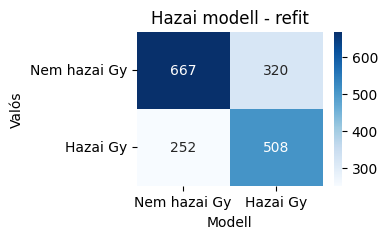

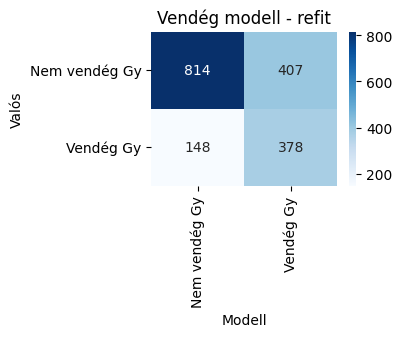

legjobb threshold #1: 0.20
legjobb threshold #2: 0.60


In [63]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_big5, logreg_home_big5, logreg_away_big5 = logreg_final(
    big5, drop_cols_home, drop_cols_away, odds, big5_params_home, big5_params_away
)

Summary for HARD VOTING model


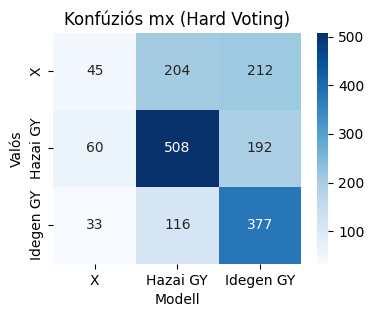

              precision    recall  f1-score   support

           0     0.3261    0.0976    0.1503       461
           1     0.6135    0.6684    0.6398       760
           2     0.4827    0.7167    0.5769       526

    accuracy                         0.5323      1747
   macro avg     0.4741    0.4943    0.4556      1747
weighted avg     0.4983    0.5323    0.4917      1747


Summary for SOFT VOTING model


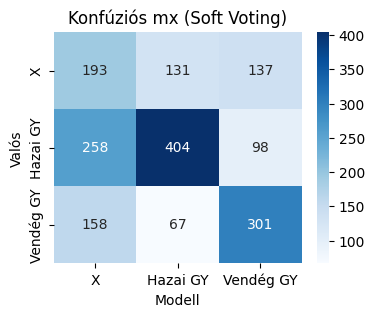

              precision    recall  f1-score   support

           0     0.3169    0.4187    0.3607       461
           1     0.6711    0.5316    0.5932       760
           2     0.5616    0.5722    0.5669       526

    accuracy                         0.5140      1747
   macro avg     0.5165    0.5075    0.5069      1747
weighted avg     0.5447    0.5140    0.5239      1747



In [64]:
pred_odds_big5 = process_predictions(test_predictions_big5)
evaluation(pred_odds_big5)

In [65]:
roi_hard, roi_soft, df_profit_hard, df_loss_hard, df_profit_soft, df_loss_soft, pred_odds_soft = betting_logreg(
    pred_odds_big5,
    stake=500
)

ROI hard : 0.30%
ROI soft : 5.36%


# U/O 2.5

## PL

In [205]:
def logistic_regression_tuning_underover(df, target_col, drop_cols=[], odds=[]):
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(len(df) * 0.8) 
    val_n = int(len(df) * 0.1)    
    
    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:]  # Last 10%

    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")
    print(f"teszt halmaz:  (i: {test_set.index[0]+1} -> {test_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]

    X_train_odds = X_train[odds]
    X_val_odds = X_val[odds]
    X_train = X_train.drop(columns=odds)
    X_val = X_val.drop(columns=odds)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    
    X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
    X_val_scaled = pd.concat([X_val_scaled, X_val_odds], axis=1)
    
    param_space = [
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l1'],
         'solver': ['liblinear', 'saga'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l2'],
         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['elasticnet'],
         'solver': ['saga'],  
         'l1_ratio': Real(0, 1),
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    ]

    tscv = TimeSeriesSplit(n_splits=5) 
    
    log_reg = LogisticRegression(random_state=1, max_iter=1000)

    bayes_search = BayesSearchCV(
        estimator=log_reg,
        search_spaces=param_space,
        n_iter=50, 
        cv=tscv, 
        scoring='f1',
        refit='f1',
        n_jobs=-1,  
        random_state=1,
        verbose=0
    )
    
    bayes_search.fit(X_train_scaled, y_train)  
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    
    y_val_probs = best_model.predict_proba(X_val_scaled)
    val_set = val_set.copy()
    val_set['P_0'] = y_val_probs[:, 0] 
    val_set['P_1'] = y_val_probs[:, 1]  

    thresholds = np.arange(0.1, 0.7, 0.01)
    f1_scores = []
    
    for t in thresholds:
        preds = (y_val_probs[:, 1] >= t).astype(int)
        f1_scores.append(f1_score(y_val, preds, average='macro'))
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    
    print(f"\nLegjobb threshold: {best_threshold:.2f}, Legjobb F1: {best_f1:.4f}")
    
    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, f1_scores, color='teal')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Legjobb: {best_threshold:.2f}')
    plt.xlabel("Határérték")
    plt.ylabel("Átlagos F1-érték")
    plt.grid()
    plt.legend()
    plt.show()

    y_pred = (y_val_probs[:, 1] >= best_threshold).astype(int)
    val_set['Predicted'] = y_pred

    print(classification_report(y_val, y_pred))
    
    plt.figure(figsize=(5, 3))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.show()
    
    feature_importances = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': np.abs(best_model.coef_).flatten()
    }).sort_values(by='importance', ascending=False)
    
    top_20_features = feature_importances.head(20)['feature'].tolist()
    print(top_20_features)

    plt.figure(figsize=(6, 4))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
    plt.xlabel("Fontosság (koef.)")
    plt.ylabel("Változó")
    plt.grid(axis='x')
    plt.show()
    
    return val_set, best_params, top_20_features



tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3327)
teszt halmaz:  (i: 3328 -> 3698)

Legjobb threshold: 0.49, Legjobb F1: 0.5581


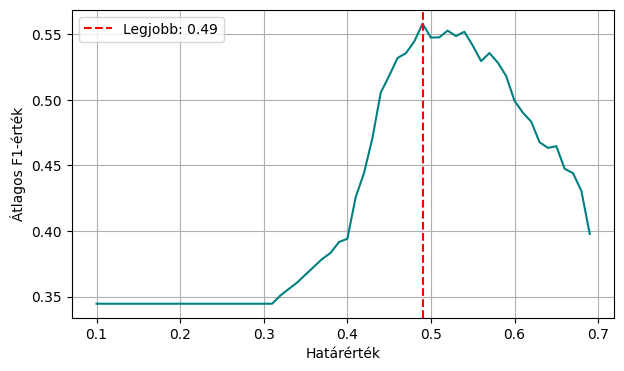

              precision    recall  f1-score   support

           0       0.57      0.42      0.48       175
           1       0.57      0.71      0.64       194

    accuracy                           0.57       369
   macro avg       0.57      0.56      0.56       369
weighted avg       0.57      0.57      0.56       369



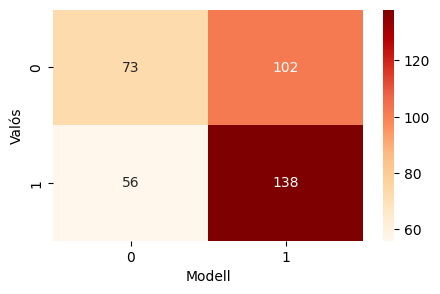

['prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'prob_HomeW_odds_market', 'prob_Draw_odds_market', 'away_xg_RA', 'away_shots_RA', 'home_expected_points_RA', 'home_xg_RA', 'away_clinicality', 'away_total_goals_RA', 'home_np_xg_difference_RA', 'away_np_xg_difference_RA', 'home_np_xg_RA', 'away_goals_for_RA', 'away_last5_draws_count', 'away_np_xg_RA', 'away_halftime_goals_RA', 'prob_AwayW_odds_market', 'home_last5_wins_count', 'home_last5_draws_count']


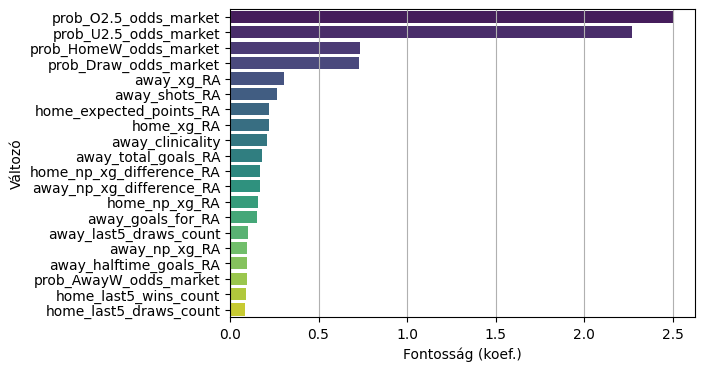

In [206]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

premier_league_tuned_UO, premier_league_params_UO, premier_league_features_UO  = logistic_regression_tuning_underover(
    premier_league,
    target_col,
    drop,
    odds
)

In [207]:
def logistic_regression_test_underover(df, target_col, drop_cols=[], odds=[], best_params={}):
    
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(round(len(df) * 0.9, 0))
    test_n = len(df) - train_n 

    train_set = df.iloc[:train_n]        
    test_set = df.iloc[train_n:] 

    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"teszt halmaz:  (i: {test_set.index[0]+1} -> {test_set.index[-1]+1})")

    X_train = train_set.drop(columns=[target_col] + drop_cols)
    y_train = train_set[target_col]
    X_test = test_set.drop(columns=[target_col] + drop_cols)
    y_test = test_set[target_col]

    X_train_odds = X_train[odds]
    X_test_odds = X_test[odds]
    X_train = X_train.drop(columns=odds)
    X_test = X_test.drop(columns=odds)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, X_test_odds], axis=1)

    log_reg = LogisticRegression(
        C=best_params.get('C', 1.0),
        penalty=best_params.get('penalty', 'l2'),
        solver=best_params.get('solver', 'liblinear'),
        class_weight=best_params.get('class_weight', None),
        # class_weight='balanced',
        random_state=best_params.get('random_state', 1),
        max_iter=1000,
        l1_ratio=best_params.get('l1_ratio', 0.5) if best_params.get('penalty') == 'elasticnet' else None  
    )
    
    log_reg.fit(X_train_scaled, y_train)

    y_test_probs = log_reg.predict_proba(X_test_scaled)
    
    thresholds = np.arange(0.1, 0.7, 0.01)
    f1_scores = []

    for t in thresholds:
        preds = (y_test_probs[:, 1] >= t).astype(int)
        f1_scores.append(f1_score(y_test, preds, average='macro'))

    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)

    print(f"\nBest threshold: {best_threshold:.2f}, Best F1: {best_f1:.4f}")

    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, f1_scores, color='teal')
    plt.axvline(best_threshold, color='red', linestyle='--')
    plt.xlabel("Határérték")
    plt.ylabel("Átlagos F1-érték")
    plt.grid()
    plt.show()

    y_pred = (y_test_probs[:, 1] >= best_threshold).astype(int)

    test_set = test_set.copy()
    test_set['P_0'] = y_test_probs[:, 0]
    test_set['P_1'] = y_test_probs[:, 1]
    test_set['Predicted'] = y_pred

    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(5, 3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.show()

    return test_set



tanító halmaz indexek: (i: 1 -> 3328)
teszt halmaz:  (i: 3329 -> 3698)

Best threshold: 0.59, Best F1: 0.5257


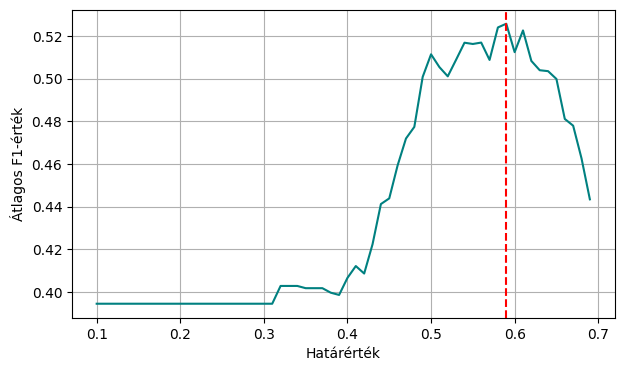

              precision    recall  f1-score   support

           0       0.38      0.46      0.42       129
           1       0.67      0.60      0.64       241

    accuracy                           0.55       370
   macro avg       0.53      0.53      0.53       370
weighted avg       0.57      0.55      0.56       370



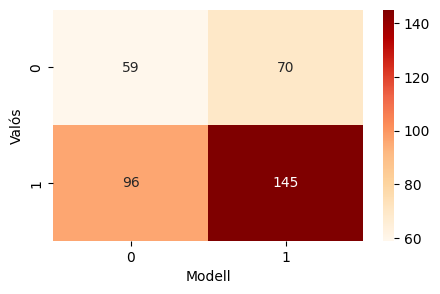

In [208]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

premier_league_test_UO = logistic_regression_test_underover(
    premier_league,
    target_col,
    drop,
    odds,
    premier_league_params_UO
)

In [209]:
def betting_logreg_underover(df, stake=1):
    
    df = df.copy() 

    df['Profit'] = 0
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )

    total_profit = df['Profit'].sum()
    total_bets = len(df)

    roi = (total_profit / (total_bets * stake)) * 100
    
    print(f"ROI: {roi:.2f}%")

    df_profit = df[df['target_o2.5'] == df['Predicted']]
    df_loss = df[df['target_o2.5'] != df['Predicted']]

    return roi, df_profit, df_loss, df

roi, df_profit, df_loss, pred_odds = betting_logreg_underover(premier_league_test_UO, stake=1)


ROI: -7.93%


>0% profit 14 fordulóban


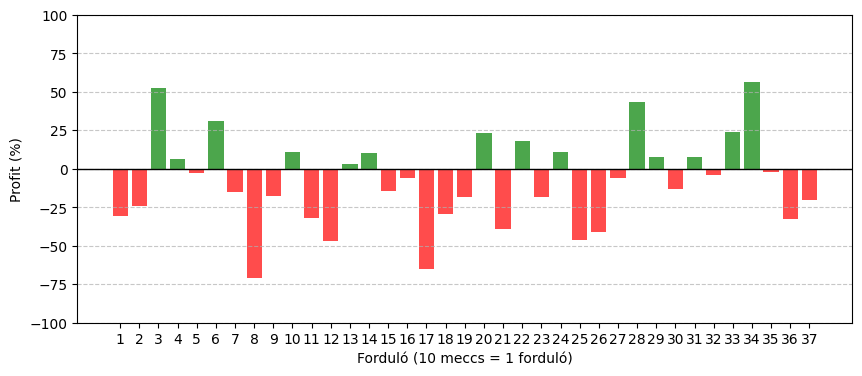

In [210]:
def ROI_sim_UO(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({'Profit': 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round['Profit'] / (roi_per_round['Total_Bets'] * stake)) * 100

    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 100)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(r'abrak/PL_ROI_UO.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_UO(premier_league_test_UO, round_size=10)

## Bundesliga


tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)
teszt halmaz:  (i: 2674 -> 2970)

Legjobb threshold: 0.58, Legjobb F1: 0.5371


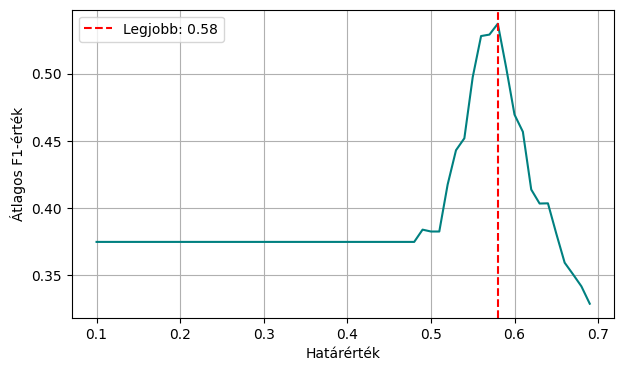

              precision    recall  f1-score   support

           0       0.44      0.51      0.47       119
           1       0.64      0.57      0.60       178

    accuracy                           0.55       297
   macro avg       0.54      0.54      0.54       297
weighted avg       0.56      0.55      0.55       297



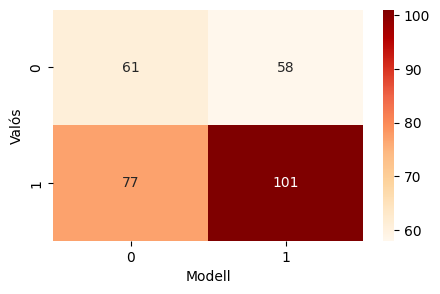

['home_deep_completions_RA', 'away_deep_completions_RA', 'home_xg_RA', 'away_total_goals_RA', 'away_shots_RA', 'home_np_xg_RA', 'home_points_RA', 'home_halftime_goals_RA', 'home_goals_against_RA', 'home_goals_for_RA', 'home_np_xg_difference_RA', 'home_expected_points_RA', 'home_points_cumulative', 'home_ppda_RA', 'home_last5_wins_count', 'home_last5_losses_count', 'home_last5_draws_count', 'home_cumulative_goals_diff', 'home_last5_over_2_5_count', 'home_last5_under_2_5_count']


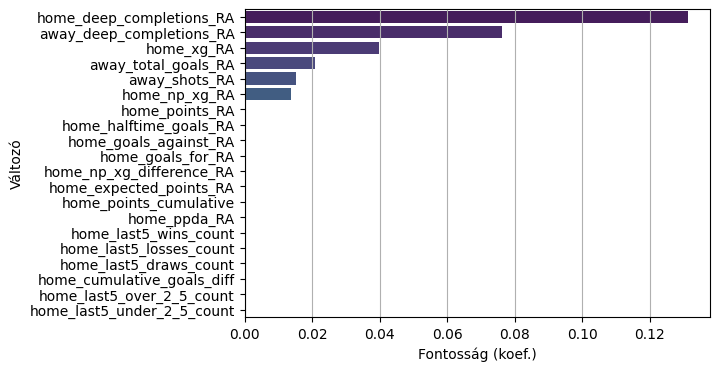

In [211]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


bundesliga_tuned_UO, bundesliga_params_UO, bundesliga_features_UO = logistic_regression_tuning_underover(
    bundesliga,  
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 2673)
teszt halmaz:  (i: 2674 -> 2970)

Best threshold: 0.59, Best F1: 0.6065


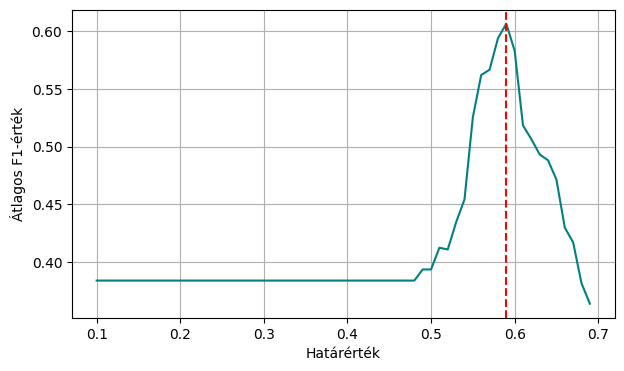

              precision    recall  f1-score   support

           0       0.50      0.58      0.53       112
           1       0.72      0.64      0.68       185

    accuracy                           0.62       297
   macro avg       0.61      0.61      0.61       297
weighted avg       0.63      0.62      0.62       297



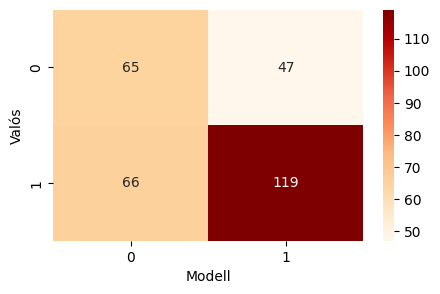

In [213]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

bundesliga_test_UO = logistic_regression_test_underover(
    bundesliga,
    target_col,
    drop,
    odds,
    bundesliga_params_UO
)

In [214]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(bundesliga_test_UO, stake=1)

ROI: 7.07%


>0% profit 20 fordulóban


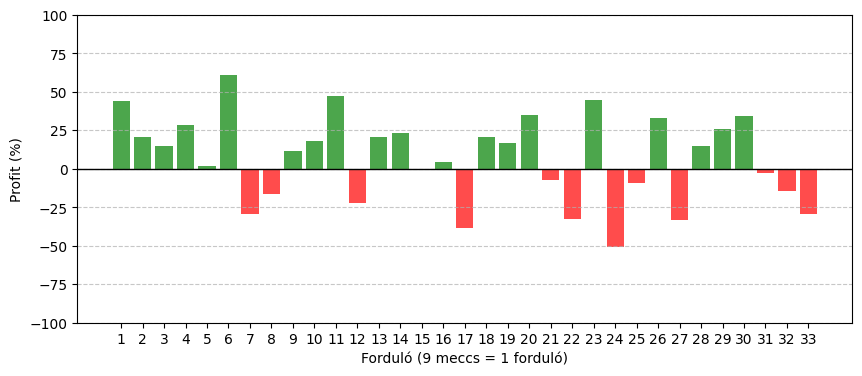

In [218]:
ROI_sim_UO(bundesliga_test_UO, round_size=9)

## Serie A


tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3219)
teszt halmaz:  (i: 3220 -> 3578)

Legjobb threshold: 0.51, Legjobb F1: 0.5323


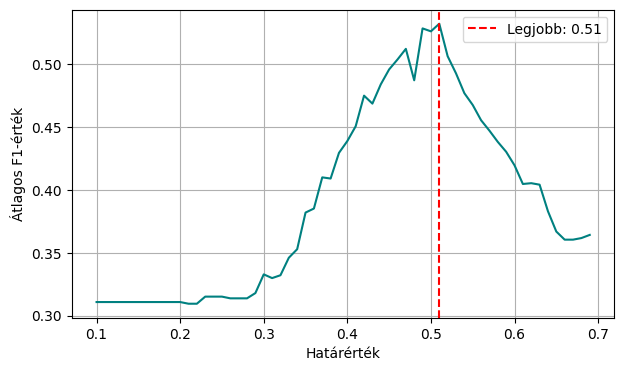

              precision    recall  f1-score   support

           0       0.58      0.70      0.63       196
           1       0.51      0.37      0.43       161

    accuracy                           0.55       357
   macro avg       0.54      0.54      0.53       357
weighted avg       0.55      0.55      0.54       357



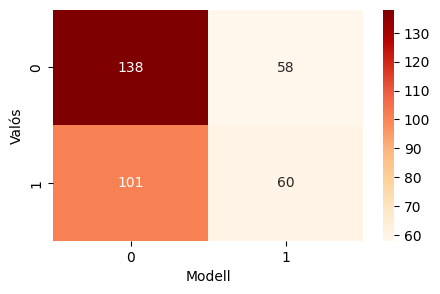

['prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'home_last5_draws_count', 'away_np_xg_RA', 'away_xg_RA', 'home_last5_draw_rate', 'away_expected_points_RA', 'home_xg_RA', 'home_goals_against_RA', 'home_np_xg_difference_RA', 'win_rate_diff', 'away_last5_over_2_5_count', 'home_goals_for_RA', 'away_goals_for_RA', 'away_clinicality', 'prob_AwayW_odds_market', 'draw_rate_diff', 'home_np_xg_RA', 'prob_HomeW_odds_market', 'away_goals_against_RA']


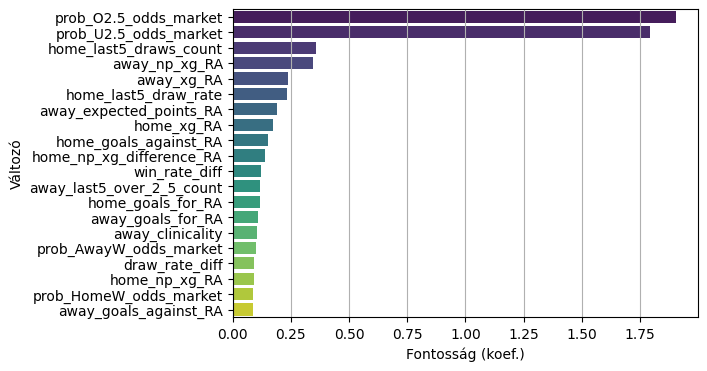

In [216]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


serie_a_tuned_UO, serie_a_params_UO, serie_a_features_UO = logistic_regression_tuning_underover(
    serie_a,  
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 3220)
teszt halmaz:  (i: 3221 -> 3578)

Best threshold: 0.43, Best F1: 0.5809


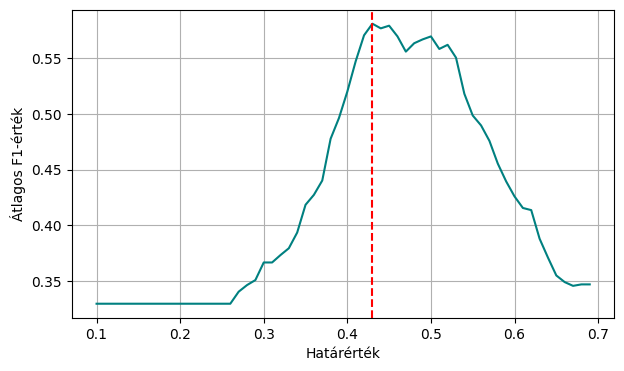

              precision    recall  f1-score   support

           0       0.64      0.44      0.52       182
           1       0.56      0.74      0.64       176

    accuracy                           0.59       358
   macro avg       0.60      0.59      0.58       358
weighted avg       0.60      0.59      0.58       358



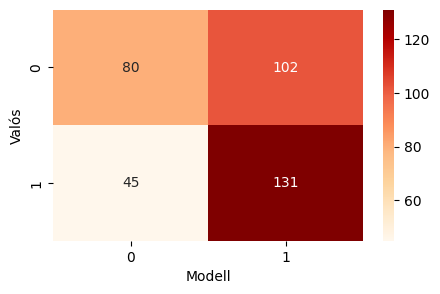

In [217]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

serie_a_test_UO = logistic_regression_test_underover(
    serie_a,
    target_col,
    drop,
    odds,
    serie_a_params_UO
)

In [219]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(serie_a_test_UO, stake=1)

ROI: 4.33%


>0% profit 22 fordulóban


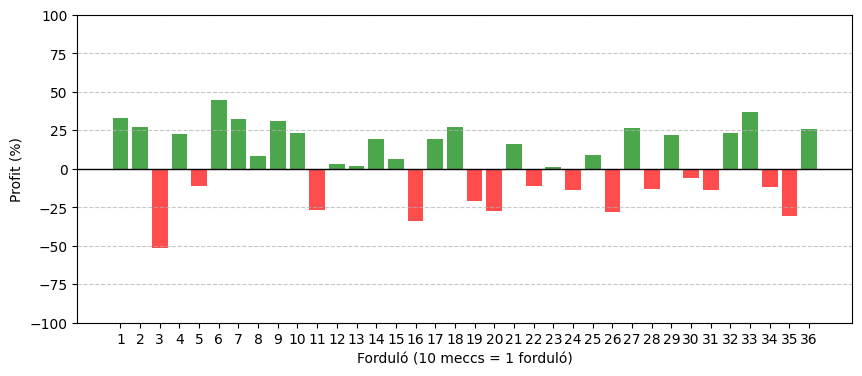

In [220]:
ROI_sim_UO(serie_a_test_UO, round_size=10)

## La Liga


tanító halmaz indexek: (i: 1 -> 2957)
validációs halmaz:  (i: 2958 -> 3326)
teszt halmaz:  (i: 3327 -> 3697)

Legjobb threshold: 0.46, Legjobb F1: 0.5771


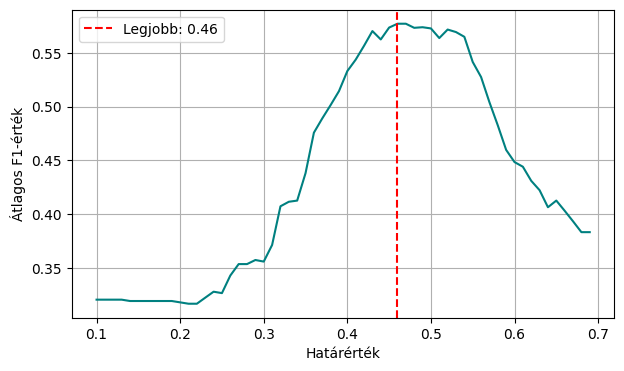

              precision    recall  f1-score   support

           0       0.62      0.53      0.57       195
           1       0.54      0.63      0.59       174

    accuracy                           0.58       369
   macro avg       0.58      0.58      0.58       369
weighted avg       0.58      0.58      0.58       369



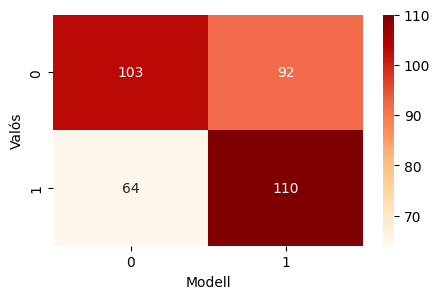

['prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'prob_Draw_odds_market', 'prob_AwayW_odds_market', 'cumulative_points_diff', 'away_cumulative_goals_diff', 'prob_HomeW_odds_market', 'away_goals_against_RA', 'GD_diff', 'home_goals_against_RA', 'home_np_xg_difference_RA', 'away_np_xg_difference_RA', 'home_clinicality', 'away_shots_RA', 'away_last5_wins_count', 'home_shots_OT_RA', 'away_goals_for_RA', 'home_goals_for_RA', 'home_points_cumulative', 'home_shots_RA']


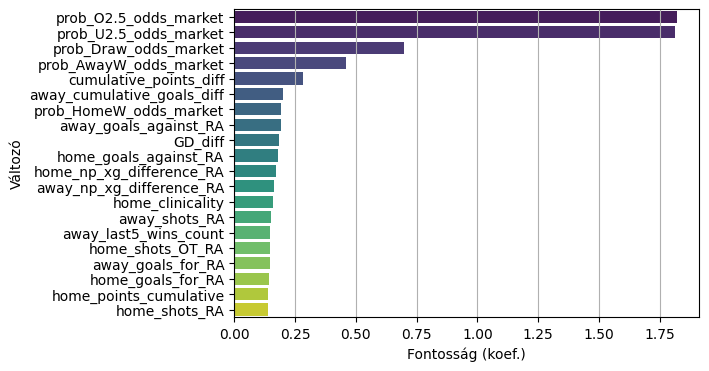

In [221]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


la_liga_tuned_UO, la_liga_params_UO, la_liga_features_UO = logistic_regression_tuning_underover(
    la_liga, 
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 3327)
teszt halmaz:  (i: 3328 -> 3697)

Best threshold: 0.47, Best F1: 0.6431


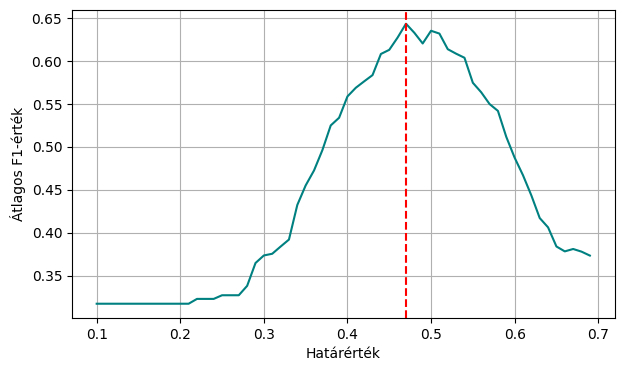

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       198
           1       0.61      0.67      0.64       172

    accuracy                           0.64       370
   macro avg       0.64      0.64      0.64       370
weighted avg       0.65      0.64      0.64       370



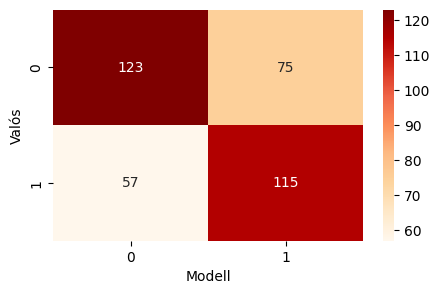

In [222]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

la_liga_test_UO = logistic_regression_test_underover(
    la_liga,
    target_col,
    drop,
    odds,
    la_liga_params_UO
)

In [223]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(la_liga_test_UO, stake=1)

ROI: 10.76%


>0% profit 24 fordulóban


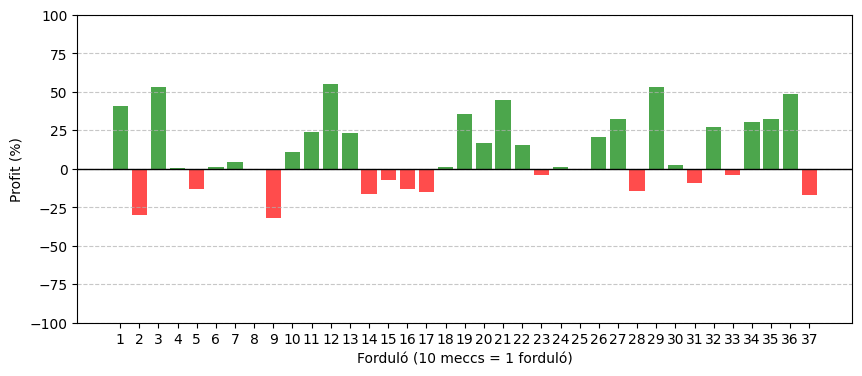

In [224]:
ROI_sim_UO(la_liga_test_UO, round_size=10)

## Ligue 1


tanító halmaz indexek: (i: 1 -> 2816)
validációs halmaz:  (i: 2817 -> 3168)
teszt halmaz:  (i: 3169 -> 3521)

Legjobb threshold: 0.57, Legjobb F1: 0.5479


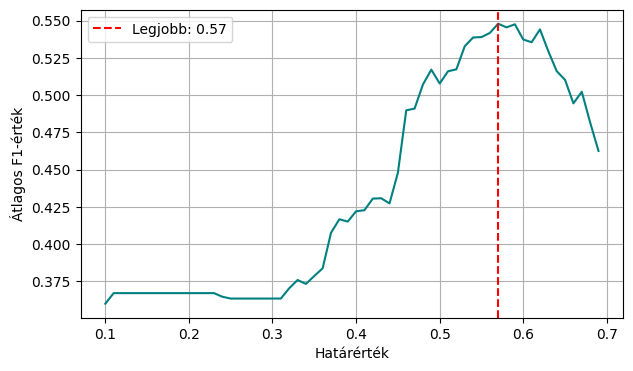

              precision    recall  f1-score   support

           0       0.49      0.59      0.53       154
           1       0.62      0.52      0.56       198

    accuracy                           0.55       352
   macro avg       0.55      0.55      0.55       352
weighted avg       0.56      0.55      0.55       352



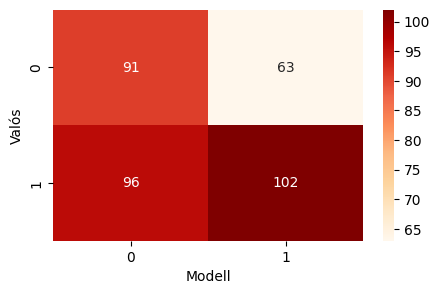

['prob_U2.5_odds_market', 'prob_O2.5_odds_market', 'home_last5_over_2_5_count', 'away_last5_under_2_5_count', 'away_last5_over_2_5_count', 'home_last5_under_2_5_count', 'away_last5_losses_count', 'away_last5_draws_count', 'home_last5_losses_count', 'home_last5_wins_count', 'home_last5_draws_count', 'away_last5_wins_count', 'prob_AwayW_odds_market', 'home_goals_for_RA', 'away_expected_points_RA', 'home_clinicality', 'home_xg_RA', 'prob_HomeW_odds_market', 'away_xg_RA', 'win_rate_diff']


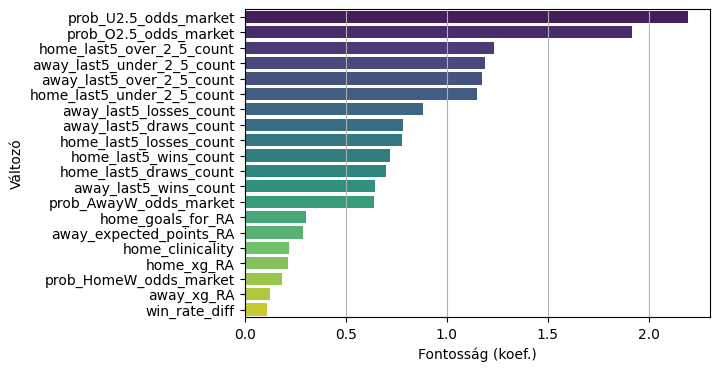

In [225]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


ligue_1_tuned_UO, ligue_1_params_UO, ligue_1_features_UO = logistic_regression_tuning_underover(
    ligue_1,  
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 3169)
teszt halmaz:  (i: 3170 -> 3521)

Best threshold: 0.53, Best F1: 0.5484


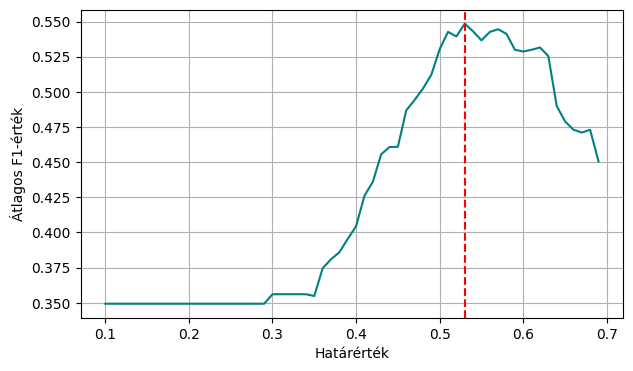

              precision    recall  f1-score   support

           0       0.52      0.48      0.50       163
           1       0.58      0.62      0.60       189

    accuracy                           0.55       352
   macro avg       0.55      0.55      0.55       352
weighted avg       0.55      0.55      0.55       352



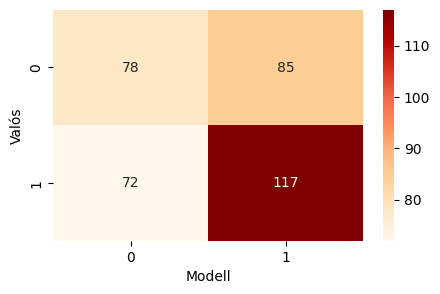

In [226]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

ligue_1_test_UO = logistic_regression_test_underover(
    ligue_1,
    target_col,
    drop,
    odds,
    ligue_1_params_UO
)

In [227]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(ligue_1_test_UO, stake=1)

ROI: -3.83%


>0% profit 15 fordulóban


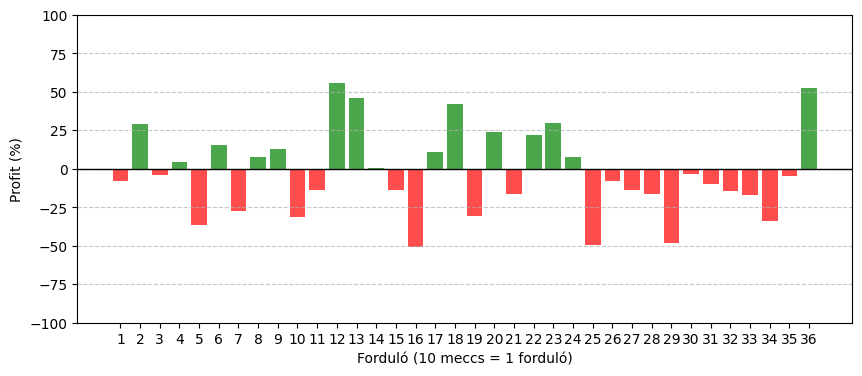

In [228]:
ROI_sim_UO(ligue_1_test_UO, round_size=10)

## Kombinált


tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)
teszt halmaz:  (i: 15718 -> 17464)

Legjobb threshold: 0.53, Legjobb F1: 0.5785


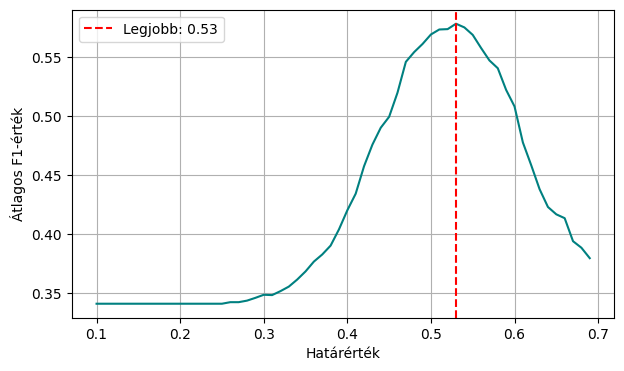

              precision    recall  f1-score   support

           0       0.56      0.60      0.58       843
           1       0.60      0.55      0.58       903

    accuracy                           0.58      1746
   macro avg       0.58      0.58      0.58      1746
weighted avg       0.58      0.58      0.58      1746



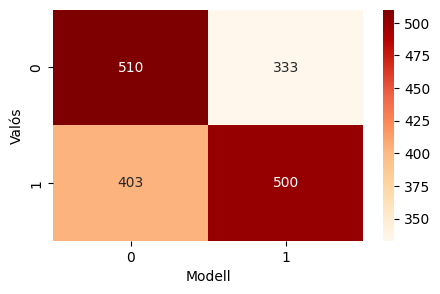

['prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'home_goals_for_RA', 'away_np_xg_RA', 'away_expected_points_RA', 'away_xg_RA', 'home_clinicality', 'home_np_xg_difference_RA', 'home_goals_against_RA', 'away_shots_RA', 'away_goals_against_RA', 'away_cumulative_goals_diff', 'cumulative_points_diff', 'home_deep_completions_RA', 'prob_AwayW_odds_market', 'away_ppda_RA', 'away_deep_completions_RA', 'home_xg_RA', 'home_points_RA', 'away_last5_over_2_5_count']


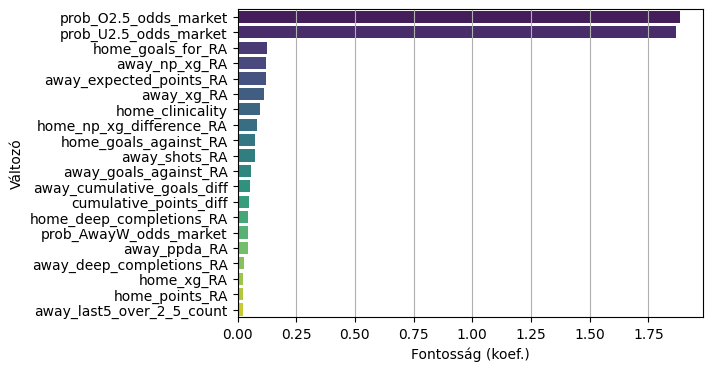

In [229]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


big5_tuned_UO, big5_params_UO, big5_features_UO = logistic_regression_tuning_underover(
    big5,  
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 15718)
teszt halmaz:  (i: 15719 -> 17464)

Best threshold: 0.51, Best F1: 0.5941


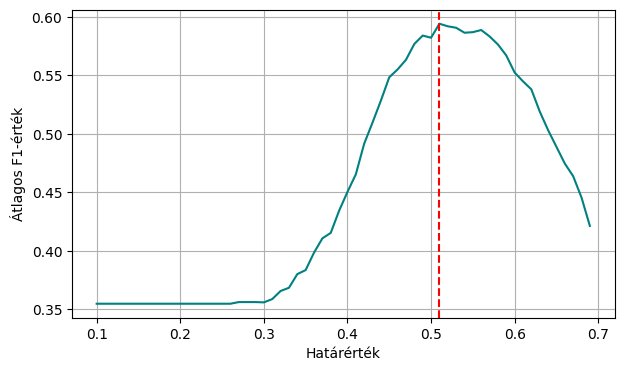

              precision    recall  f1-score   support

           0       0.57      0.49      0.53       786
           1       0.63      0.70      0.66       960

    accuracy                           0.60      1746
   macro avg       0.60      0.59      0.59      1746
weighted avg       0.60      0.60      0.60      1746



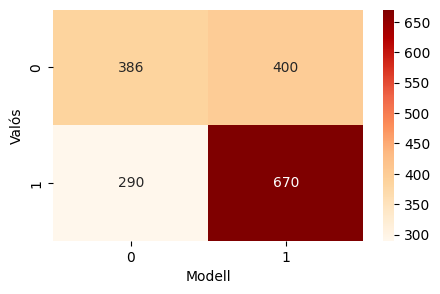

In [230]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

big5_test_UO = logistic_regression_test_underover(
    big5,
    target_col,
    drop,
    odds,
    big5_params_UO
)

In [231]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(big5_test_UO, stake=1)

ROI: -0.27%


>0% profit 18 fordulóban


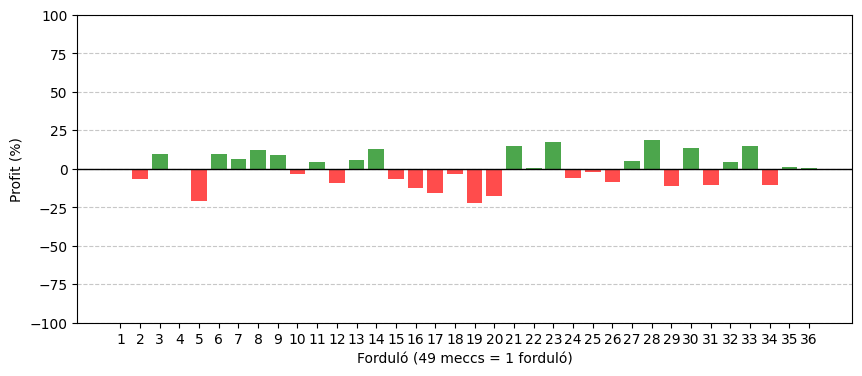

In [236]:
ROI_sim_UO(big5_test_UO, round_size=49)